In [69]:
%matplotlib inline

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import pandas as pd


class MF(nn.Module):
    def __init__(self, n_coeffs, n_comps, n_pix):
        super(MF, self).__init__()
        self.cfs = nn.Parameter(torch.rand(n_coeffs, n_comps, requires_grad=True))
        self.cmps = nn.Parameter(torch.rand(n_comps, n_pix, requires_grad=True))

    def forward(self):
        return torch.matmul(self.cfs,self.cmps)


def unit_norm(cmps):
    return torch.sum(torch.abs(torch.norm(cmps, dim=1) - (torch.ones(12)*20).to(device)))

ncomps = 12
λ = 1e-6
μ = 1e-7

cuda:0


nbart_red
nbart_green
nbart_blue
nbart_nir_1
nbart_nir_2
nbart_swir_2
nbart_swir_3


<BarContainer object of 7 artists>

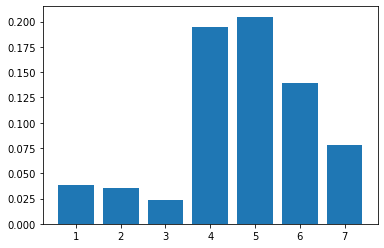

In [70]:
ds = xr.open_dataset(f"/data/pca_act/000_clean.nc")
ti_nan = (np.count_nonzero(np.isnan(ds.nbart_blue.values), axis=(1,2)))<.66*160000
ds = ds.isel(time=ti_nan)

stack = np.empty((0,400,400))
for fname in ds:
    print(fname)
    band = ds[fname]
    band = band.interpolate_na(dim='time')
    band = band.interpolate_na(dim='time', method='nearest', fill_value='extrapolate')
    stack = np.append(stack, band.values, axis=0)

stack = stack.reshape(-1, 160000) / 1e4

plt.bar(np.arange(1,8),np.mean(stack.reshape(7,71,160000),axis=(1,2)))

In [26]:
pca = PCA(n_components=ncomps).fit(stack)
coeffs = pca.transform(stack)
pca_decomp = pca.inverse_transform(coeffs)

print("PCA MSE 12 comp", np.mean(np.square(pca_decomp - stack)))

pca = PCA(n_components=11).fit(stack)
coeffs = pca.transform(stack)
pca_decomp = pca.inverse_transform(coeffs)

print("PCA MSE 11 comp", np.mean(np.square(pca_decomp - stack)))

pca = PCA(n_components=10).fit(stack)
coeffs = pca.transform(stack)
pca_decomp = pca.inverse_transform(coeffs)

print("PCA MSE 10 comp", np.mean(np.square(pca_decomp - stack)))

pca = PCA(n_components=9).fit(stack)
coeffs = pca.transform(stack)
pca_decomp = pca.inverse_transform(coeffs)

print("PCA MSE 9 comp", np.mean(np.square(pca_decomp - stack)))

pca = PCA(n_components=8).fit(stack)
coeffs = pca.transform(stack)
pca_decomp = pca.inverse_transform(coeffs)

print("PCA MSE 8 comp", np.mean(np.square(pca_decomp - stack)))

PCA MSE 12 comp 5.552699591966187e-05
PCA MSE 11 comp 5.9733305171602925e-05
PCA MSE 10 comp 6.468225507122247e-05
PCA MSE 9 comp 6.986040641016541e-05
PCA MSE 8 comp 7.656027257432712e-05


0 2994.22509765625 9.778436660766602 2544.5703125
100 1227.8251953125 0.008826596662402153 871.3860473632812
200 1197.7841796875 0.007786229718476534 946.1788330078125
300 1196.3770751953125 0.0077525959350168705 956.20458984375
400 1198.5445556640625 0.00774427829310298 959.1441650390625
500 1200.558837890625 0.007739427033811808 960.8511962890625
600 1202.217041015625 0.007736263796687126 962.11962890625
700 1203.6270751953125 0.0077340384013950825 963.1377563476562
800 1204.839599609375 0.0077323904260993 963.9862060546875
900 1205.958251953125 0.007731123361736536 964.7102661132812
0.007730123121291399 0.0
0 6187.4970703125 0.007730123121291399 1.8576278686523438
100 6183.33740234375 0.007724418304860592 2.644390106201172
200 6179.1357421875 0.007724417373538017 2.8067760467529297
300 6175.0947265625 0.007724417373538017 2.959321975708008
400 6171.18115234375 0.007724418304860592 3.1051597595214844
500 6167.380859375 0.00772441690787673 3.24554443359375
600 6163.6845703125 0.007724

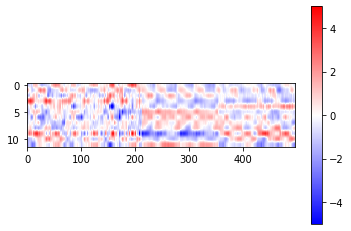

In [63]:
stack_mean = np.mean(stack, axis=0)
target = torch.from_numpy(stack-stack_mean).float().to(device)

ncoeffs = stack.shape[0]
npix = 160000

net = MF(ncoeffs, ncomps, npix)
net.to(device)

mse = nn.MSELoss(reduction='mean')

opt = optim.AdamW(net.parameters(), lr=1.0)

n_epoch  = 1000
for epoch in range(n_epoch):
    yhat = net()
    loss = mse(yhat, target) #+ λ*unit_norm(net.cmps)# + μ*torch.norm(net.cfs, p=1)

    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(epoch, torch.norm(net.cfs, p=1).item(), mse(yhat, target).item(), unit_norm(net.cmps).item())

with torch.no_grad():
    net.cfs.data = net.cfs.data*torch.norm(net.cmps, dim=1).data/20
    net.cmps.data = net.cmps.data/torch.norm(net.cmps, dim=1).data[:,None]*20


opt = optim.AdamW(net.parameters(), lr=0.001)

n_epoch  = 1000
for epoch in range(n_epoch):
    yhat = net()
    loss = mse(yhat, target) #+ λ*unit_norm(net.cmps)# + μ*torch.norm(net.cfs, p=1)

    if epoch == 0:
        print(loss.item(), unit_norm(net.cmps).item())

    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(epoch, torch.norm(net.cfs, p=1).item(), mse(yhat, target).item(), unit_norm(net.cmps).item())

with torch.no_grad():
    net.cfs.data = net.cfs.data*torch.norm(net.cmps, dim=1).data/20
    net.cmps.data = net.cmps.data/torch.norm(net.cmps, dim=1).data[:,None]*20

cfs = net.cfs.detach().cpu().numpy()
print("cfs size:", cfs.shape, cfs.size)
print("Zeros before:", np.sum(np.isclose(cfs, np.zeros(cfs.shape), rtol=1e-03, atol=1e-04)))
print(f"Zeros after: 0.1->{np.sum(np.abs(cfs)<0.1)} 0.01->{np.sum(np.abs(cfs)<0.01)} 0.001->{np.sum(np.abs(cfs)<0.001)} 0.0001->{np.sum(np.abs(cfs)<0.0001)} 0.00001->{np.sum(np.abs(cfs)<0.00001)} 0.000001->{np.sum(np.abs(cfs)<0.000001)} 0.0000001->{np.sum(np.abs(cfs)<0.0000001)}")

plt.imshow(cfs.T, vmin=-5.0, vmax=5.0, aspect=10, cmap='bwr')
plt.colorbar()

0 1046.992431640625 5.5531087127747014e-05 1.4439029693603516
100 901.6904296875 5.9242520364932716e-05 7.217550277709961
200 798.884521484375 5.953368963673711e-05 12.13115119934082
300 716.084716796875 5.970349593553692e-05 15.483570098876953
400 697.68798828125 5.924826837144792e-05 16.277427673339844
500 692.3007202148438 5.892915578442626e-05 16.40155792236328
600 688.5184326171875 5.8922767493641004e-05 16.662107467651367
700 684.56201171875 5.886040162295103e-05 16.788131713867188
800 681.5665893554688 5.87316753808409e-05 16.92757797241211
900 679.6279296875 5.8839279517997056e-05 16.934022903442383
1000 678.1961059570312 5.873633563169278e-05 16.665184020996094
1100 677.736572265625 5.881300967303105e-05 16.714067459106445
1200 676.9957885742188 5.872576730325818e-05 16.659921646118164
1300 676.3502197265625 5.8618610637495294e-05 16.615827560424805
1400 675.0980834960938 5.864379272679798e-05 16.791067123413086
1500 674.32958984375 5.8586025261320174e-05 16.75552749633789
160

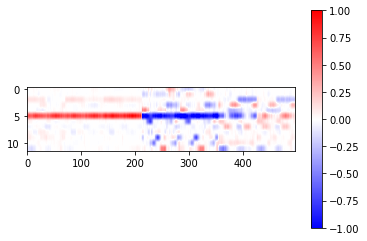

In [5]:
opt = optim.AdamW(net.parameters(), lr=0.01)
n_epoch  = 2000
for epoch in range(n_epoch):
    yhat = net()
    loss = mse(yhat, target) + λ*unit_norm(net.cmps) + μ*torch.norm(net.cfs, p=1)
    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(epoch, torch.norm(net.cfs, p=1).item(), mse(yhat, target).item(), unit_norm(net.cmps).item())

cfs = net.cfs.detach().cpu().numpy()
print("Zeros after:", np.sum(np.isclose(cfs, np.zeros(cfs.shape), rtol=1e-03, atol=1e-04)))
print(f"Zeros after: 0.1->{np.sum(np.abs(cfs)<0.1)} 0.01->{np.sum(np.abs(cfs)<0.01)} 0.001->{np.sum(np.abs(cfs)<0.001)} 0.0001->{np.sum(np.abs(cfs)<0.0001)} 0.00001->{np.sum(np.abs(cfs)<0.00001)} 0.000001->{np.sum(np.abs(cfs)<0.000001)} 0.0000001->{np.sum(np.abs(cfs)<0.0000001)}")
plt.imshow(cfs.T, vmin=-1.0, vmax=1.0, aspect=10, cmap='bwr')
plt.colorbar()

0 649.4329833984375 5.873179907212034e-05 22.18264389038086
100 541.318115234375 6.486045458586887e-05 28.167770385742188
200 518.8529052734375 6.52830203762278e-05 31.381919860839844
300 514.3569946289062 6.562758790096268e-05 31.852312088012695
400 512.410888671875 6.570507684955373e-05 32.24073791503906
500 513.0077514648438 6.591351120732725e-05 31.850486755371094
600 513.0623779296875 6.579238106496632e-05 31.669750213623047
700 511.2922058105469 6.601023051189259e-05 31.931381225585938
800 510.9870910644531 6.606365786865354e-05 32.2782096862793
900 510.52044677734375 6.621194916078821e-05 31.490970611572266
1000 509.08599853515625 6.628101255046204e-05 31.763879776000977
1100 508.6533508300781 6.640396895818412e-05 32.011817932128906
1200 507.1803894042969 6.661217048531398e-05 32.07820129394531
1300 508.1854248046875 6.660826329607517e-05 31.638988494873047
1400 508.2798767089844 6.65353873046115e-05 31.54286003112793
1500 508.29974365234375 6.661636143689975e-05 31.34222412109

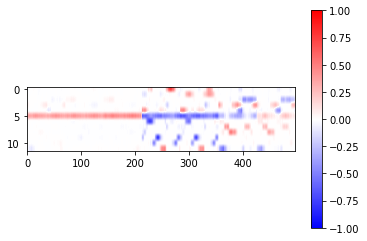

In [6]:
opt = optim.AdamW(net.parameters(), lr=0.01)
n_epoch  = 2000
for epoch in range(n_epoch):
    yhat = net()
    loss = mse(yhat, target) + λ*unit_norm(net.cmps) + 2*μ*torch.norm(net.cfs, p=1)
    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(epoch, torch.norm(net.cfs, p=1).item(), mse(yhat, target).item(), unit_norm(net.cmps).item())

cfs = net.cfs.detach().cpu().numpy()
print("Zeros after 2x:", np.sum(np.isclose(cfs, np.zeros(cfs.shape), rtol=1e-03, atol=1e-04)))
print(f"Zeros after 2x: 0.1->{np.sum(np.abs(cfs)<0.1)} 0.01->{np.sum(np.abs(cfs)<0.01)} 0.001->{np.sum(np.abs(cfs)<0.001)} 0.0001->{np.sum(np.abs(cfs)<0.0001)} 0.00001->{np.sum(np.abs(cfs)<0.00001)} 0.000001->{np.sum(np.abs(cfs)<0.000001)} 0.0000001->{np.sum(np.abs(cfs)<0.0000001)}")

opt = optim.AdamW(net.parameters(), lr=0.01)
n_epoch  = 2000
for epoch in range(n_epoch):
    yhat = net()
    loss = mse(yhat, target) + λ*unit_norm(net.cmps) + 4*μ*torch.norm(net.cfs, p=1)
    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(epoch, torch.norm(net.cfs, p=1).item(), mse(yhat, target).item(), unit_norm(net.cmps).item())

cfs = net.cfs.detach().cpu().numpy()
print("Zeros after 4x:", np.sum(np.isclose(cfs, np.zeros(cfs.shape), rtol=1e-03, atol=1e-04)))
print(f"Zeros after 4x: 0.1->{np.sum(np.abs(cfs)<0.1)} 0.01->{np.sum(np.abs(cfs)<0.01)} 0.001->{np.sum(np.abs(cfs)<0.001)} 0.0001->{np.sum(np.abs(cfs)<0.0001)} 0.00001->{np.sum(np.abs(cfs)<0.00001)} 0.000001->{np.sum(np.abs(cfs)<0.000001)} 0.0000001->{np.sum(np.abs(cfs)<0.0000001)}")
plt.imshow(cfs.T, vmin=-1.0, vmax=1.0, aspect=10, cmap='bwr')
plt.colorbar()

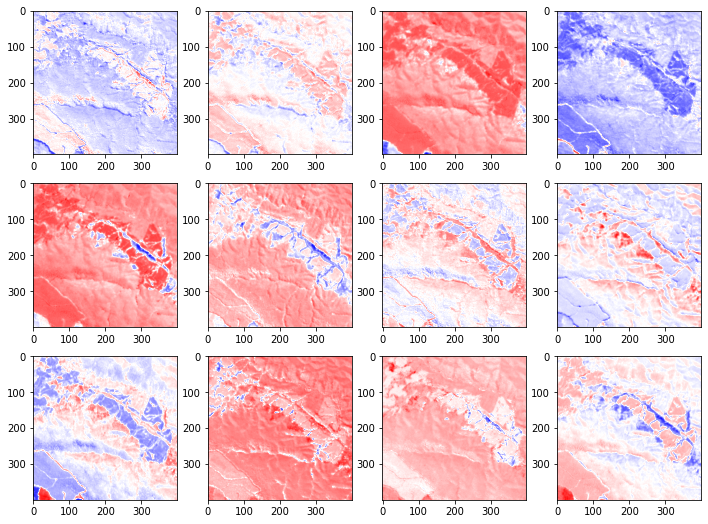

In [7]:
nn_comps = net.cmps.detach().cpu().numpy().reshape(12,400,400)


fig=plt.figure(figsize=(12, 9))
columns = 4
rows = 3

for i in range(12):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(nn_comps[i], cmap='bwr')